In [1]:
import xarray as xr
import numpy as np

from scipy import stats                                                         

import matplotlib.pyplot as plt
import seaborn as sns

import sstats.tseries as ts
import sstats.sigp as sigp
import sstats.hfreq as hf

# dev
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
# https://www.wrighters.io/using-autoreload-to-speed-up-ipython-and-jupyter-work/
%reload_ext autoreload
%autoreload 1
#%aimport sstats
%aimport sstats

In [2]:
from sympy import Symbol, pi, atan, factor, lambdify

In [3]:
u_low = hf.low_frequency_signal()

In [4]:
omegac = Symbol('omega_c', positive=True)
T_sp, U_sp = u_low.p['T'], u_low.p['U']
omega_sp, tau_sp = u_low.omega, u_low.tau

## Autocovariance and power spectra

In [5]:
print('Power spectra formula (for an exponential autocorrelation): ')
u_low.spectrum

Power spectra formula (for an exponential autocorrelation): 


2*T*U**2/(T**2*omega**2 + 1)

In [6]:
tau = np.arange(0,300,1/24)
rad = 2*np.pi
om = np.linspace(0,10,10000)

In [7]:
psd = lambda omega,T,U : u_low.spectrum_lbd(omega,T,U)
exp_func = lambda tau,T,U : U*np.exp(-tau/T)

In [8]:
Tbar = [2,20,200]
U = 1
omega_c = [0.2,0.5,0.9]

### Figures 

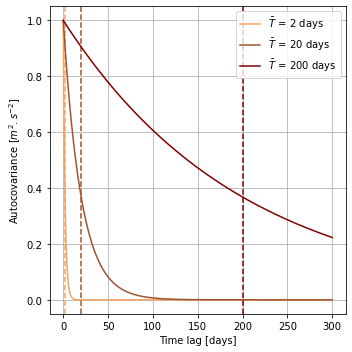

In [9]:
colors = ['sandybrown','sienna','maroon']
fig,ax = plt.subplots(figsize=(5,5))
for i,T in enumerate(Tbar):
    c = colors[i]
    ax.plot(tau,exp_func(tau,T,U),c=c,label=r'$\bar T$ = %s days'%T)
    ax.axvline(T,linestyle='--',c=c)
ax.grid();ax.legend();
ax.set_ylabel(r'Autocovariance [$m^2.s^{-2}$]');
ax.set_xlabel('Time lag [days]');
fig.tight_layout();
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/autocov_th_methodo.pdf')

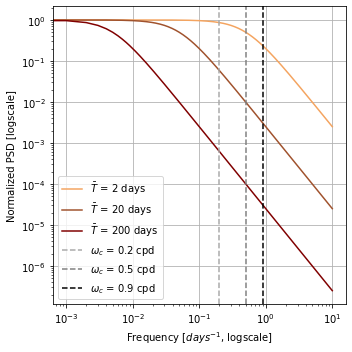

In [10]:
col_omega = ['darkgrey','grey','k']
fig,ax = plt.subplots(figsize=(5,5))
for i,T in enumerate(Tbar):
    c = colors[i]
    ax.plot(om,psd(om,T,U)/psd(om[0],T,U),c=c,label=r'$\bar T$ = %s days'%T)
for i,T in enumerate(Tbar):
    c = col_omega[i]
    ax.axvline(omega_c[i],linestyle='--',c=c,label=r'$\omega_c$ = %s cpd'%omega_c[i])
ax.grid();ax.legend();ax.set_yscale('log');ax.set_xscale('log')
ax.set_ylabel(r'Normalized PSD [logscale]');
ax.set_xlabel('Frequency [$days^{-1}$, logscale]');
fig.tight_layout();
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/spectra_th_methodo.pdf')

## Energy estimates

In [11]:
I_low = u_low.spectrum.integrate((omega_sp, 0, omegac)) *2  /2/pi
I_low = I_low.simplify()
E_low = lambdify([U_sp, T_sp, omegac], I_low)

print('Energy at low frequency after filtering : ')
I_low

Energy at low frequency after filtering : 


2*U**2*atan(T*omega_c)/pi

In [12]:
omega_c = np.linspace(0,2,10000)
tbar = np.linspace(0,300,30000)
loss = lambda omega,T : 2*np.arctan(T*omega)/np.pi

In [13]:
Omega_c, Tbar = np.meshgrid(omega_c,tbar)


In [14]:
Tb,om_c = np.meshgrid([2,20,200],[0.2,0.5,0.9])

In [15]:
dt = 1/24
DT = tbar.max()
N = DT/dt
Ne = lambda T,N,dt : N*(1-np.exp(-2*dt/T))

### Figures

In [16]:
import matplotlib as mpl
mpl.rcParams['font.size']=13

In [17]:
Colors = np.meshgrid(colors,[2,20,200])[0]

In [18]:
manual_locations = [(5, 0.3), (100, 0.2), (2, 0.1)]

KeyboardInterrupt: 

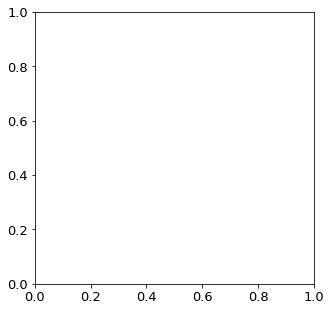

In [19]:
from matplotlib import ticker
fmt_func = lambda x,pos: "{:1.1f}".format(x)
fmt = ticker.FuncFormatter(fmt_func)

fig,ax = plt.subplots(figsize=(5,5))
cs = ax.contourf(Tbar.T,Omega_c.T,loss(Omega_c,Tbar).T,levels=500, vmax=1.01,cmap='bone')
plt.colorbar(cs);
ax.set_xscale('log')
CS = ax.contour(Tbar.T,Omega_c.T,loss(Omega_c,Tbar).T,levels=[0.1,0.5,0.9],colors='r')
ax.clabel(CS, CS.levels, inline=1, fontsize=13,fmt=fmt,manual=manual_locations)
ax.scatter(Tb.flatten(),om_c.flatten(),c=Colors.flatten(),zorder=1,alpha=1);
ax.set_ylim(0,1.25);
ax.set_ylabel('Frequency [cpd]');ax.set_xlabel('Timescales [days, logscale]')
fig.tight_layout();
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/energyloss_th_methodo.png')

In [22]:
print('Cutoff frequency, 0.2 cpd')
for T in [2,20,200]:
    print(r'Decorrelation timescale = %s days'%T,'     :       ', 'loss = ', np.around(loss(0.2,T),decimals=1))
print('---------------------------------------')    
print('Cutoff frequency, 0.5 cpd')
for T in [2,20,200]:
    print(r'Decorrelation timescale = %s days'%T,'     :       ', 'loss = ', np.around(loss(0.5,T),decimals=1))
print('---------------------------------------')    
print('Cutoff frequency, 0.9 cpd')
for T in [2,20,200]:
    print(r'Decorrelation timescale = %s days'%T,'     :       ', 'loss = ', np.around(loss(0.9,T),decimals=1))

Cutoff frequency, 0.2 cpd
Decorrelation timescale = 2 days      :        loss =  0.2
Decorrelation timescale = 20 days      :        loss =  0.8
Decorrelation timescale = 200 days      :        loss =  1.0
---------------------------------------
Cutoff frequency, 0.5 cpd
Decorrelation timescale = 2 days      :        loss =  0.5
Decorrelation timescale = 20 days      :        loss =  0.9
Decorrelation timescale = 200 days      :        loss =  1.0
---------------------------------------
Cutoff frequency, 0.9 cpd
Decorrelation timescale = 2 days      :        loss =  0.7
Decorrelation timescale = 20 days      :        loss =  1.0
Decorrelation timescale = 200 days      :        loss =  1.0


/var/folders/8p/ctkm_wt55j54lh09mdw3yv0r00g___/T/ipykernel_2653/3644365525.py:4: RuntimeWarning: divide by zero encountered in true_divide
  Ne = lambda T,N,dt : N*(1-np.exp(-2*dt/T))


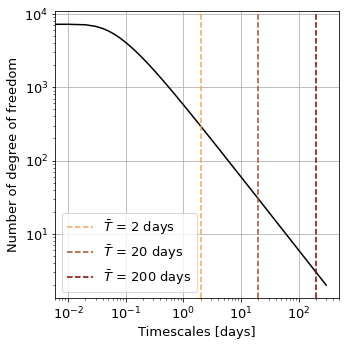

In [100]:
fig,ax = plt.subplots(figsize=(5,5))
ax.plot(tbar,Ne(tbar,N,dt),c='k');ax.set_yscale('log');ax.set_xscale('log')
ax.set_ylabel('Number of degree of freedom');ax.set_xlabel('Timescales [days]')
for i,T in enumerate([2,20,200]):
    ax.axvline(T,c=colors[i],linestyle='--',label=r'$\bar T$ = %s days'%T)
ax.legend();ax.grid()
fig.tight_layout();
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/c.pdf')

In [112]:
print('Effective number of degree of freeedom:')
for T in [2,20,200]:
    print(r'Decorrelation timescale = %s days'%T,'     :       ', 'Ne = ', np.around(Ne(T,N,dt),decimals=1))

Effective number of degree of freeedom:
Decorrelation timescale = 2 days      :        Ne =  293.8
Decorrelation timescale = 20 days      :        Ne =  29.9
Decorrelation timescale = 200 days      :        Ne =  3.0
